###  1 - Carregar os pactotes e configurações do ambiente python

In [22]:
import os.path as osp, os
os.environ["CUDA_VISIBLE_DEVICES"] = ''
import torch, numpy as np
from data.graphdataset import ThermoMLDataset, ramirez, ThermoMLpara
from train.train import create_model
from train.models import PNAPCSAFT
from train.model_deg import calc_deg
from data.graph import from_InChI
from train.parametrisation import MAPE, rhovp_data
import matplotlib.pyplot as plt
from configs.default import get_config
config = get_config()
device = torch.device("cpu")
model_dtype = torch.float64
deg_model2 = calc_deg("thermoml", './')
deg_model1 = calc_deg("ramirez", './')
from demo.utils import loadckp, plotdata
torch.cuda.is_available()
import networkx as nx 
from torch_geometric.utils import to_networkx
from torch_geometric.nn import summary

### 2 - Carregar os dados de parametrização e dados experimentais de densidade e pressão de vapor

* Dados de parametrização

In [23]:
ra_loader = ramirez("./data/ramirez2022")
ra_para = {}
for graph in ra_loader:
    inchi, para = graph.InChI, graph.para.view(-1, 3).round(decimals=2)
    ra_para[inchi] = para.tolist()[0]

In [24]:
tml_loader = ThermoMLpara("./data/thermoml")
tml_para = {}
for graph in tml_loader:
    inchi, para = graph.InChI, graph.para.view(-1, 3).round(decimals=2)
    tml_para[inchi] = para.tolist()[0]

* Dados de pressão de vapor e densidade 

In [25]:
path = osp.join("data", "thermoml")
testloader = ThermoMLDataset(path)


### 3 - Criar e inicializar a rede


In [26]:
config.propagation_depth=4
config.hidden_dim=128
config.num_mlp_layers=2
config.pre_layers=1
config.post_layers=3

In [27]:
model2 = create_model(config, deg_model2).to(device, model_dtype).eval()
model1 = create_model(config, deg_model1).to(device, model_dtype).eval()

In [28]:
dummy = tml_loader[0]
dummy.x = dummy.x.to(model_dtype)
dummy.edge_attr = dummy.edge_attr.to(model_dtype)
dummy.edge_index = dummy.edge_index.to(torch.int64)
print(summary(model2, dummy, max_depth=2))

+---------------------------+----------------------------+----------------+-----------+
| Layer                     | Input Shape                | Output Shape   | #Param    |
|---------------------------+----------------------------+----------------+-----------|
| PNAPCSAFT                 | [8, 8]                     | [1, 3]         | 1,393,431 |
| ├─(convs)ModuleList       | --                         | --             | 1,348,244 |
| │    └─(0)PNAConv         | [8, 9], [2, 14], [14, 3]   | [8, 128]       | 41,108    |
| │    └─(1)PNAConv         | [8, 128], [2, 14], [14, 3] | [8, 128]       | 435,712   |
| │    └─(2)PNAConv         | [8, 128], [2, 14], [14, 3] | [8, 128]       | 435,712   |
| │    └─(3)PNAConv         | [8, 128], [2, 14], [14, 3] | [8, 128]       | 435,712   |
| ├─(batch_norms)ModuleList | --                         | --             | 1,024     |
| │    └─(0)BatchNorm       | [8, 128]                   | [8, 128]       | 256       |
| │    └─(1)BatchNorm       | [8

* Carregar os parâmetros dos modelos 1 e 2 treinados que foram salvos

In [29]:
ckp_path = "./train/checkpoints/model2-6_83e6.pth"
loadckp(ckp_path, model2)
ckp_path = "./train/checkpoints/model1-4_54e6.pth"
loadckp(ckp_path, model1)

model checkpoint step 6830000
model checkpoint step 4540000


### 4 - Fazer a predição dos parâmetros a partir dos grafos

* InChI da molécula

In [30]:
inchi = "InChI=1S/C5H6O2/c6-4-5-2-1-3-7-5/h1-3,6H,4H2"

* Grafo da molécula

Data(x=[7, 9], edge_index=[2, 14], edge_attr=[14, 3], InChI='InChI=1S/C5H6O2/c6-4-5-2-1-3-7-5/h1-3,6H,4H2')
### Nós (átomos) do grafo e seus atributos### 
tensor([[6, 0, 3, 5, 1, 0, 0, 0, 1],
        [6, 0, 3, 5, 1, 0, 0, 0, 1],
        [6, 0, 3, 5, 1, 0, 0, 0, 1],
        [6, 0, 4, 5, 2, 0, 0, 0, 0],
        [6, 0, 3, 5, 0, 0, 0, 0, 1],
        [8, 0, 2, 5, 1, 0, 0, 0, 0],
        [8, 0, 2, 5, 0, 0, 0, 0, 1]])
### Arestas (ligações químicas) da molécula e seus atributos###
tensor([[1, 0, 0],
        [2, 0, 0],
        [1, 0, 0],
        [2, 0, 0],
        [2, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [2, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]])


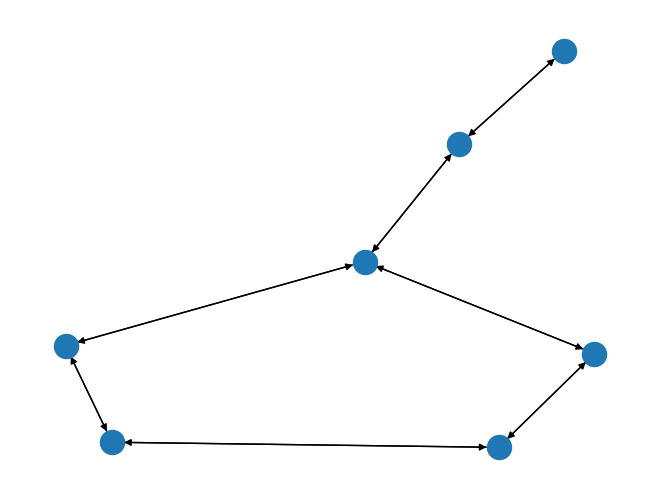

In [31]:
grafo = from_InChI(inchi).to(device)
print(grafo)
print("### Nós (átomos) do grafo e seus atributos### ")
print(grafo.x)
print("### Arestas (ligações químicas) da molécula e seus atributos###")
print(grafo.edge_attr)
nxg = to_networkx(grafo)
nx.draw(nxg)

* Parâmetros previstos pelos Modelo 1 e 2

In [32]:
grafo.x = grafo.x.to(model_dtype)
grafo.edge_attr = grafo.edge_attr.to(model_dtype)
grafo.edge_index = grafo.edge_index.to(torch.int64)
with torch.no_grad():
    parametros_modelo_1 = model1(grafo)
    parametros_modelo_2 = model2(grafo)
print("######### parâmetros previstos #########")
print("Pelo modelo 1:")
print("[número de segmentos, diâmetros de segmento, energia de dispersão]")
print(parametros_modelo_1[0].numpy().round(4))
print("Pelo modelo 2:")
print("[número de segmentos, diâmetros de segmento, energia de dispersão]")
print(parametros_modelo_2[0].numpy().round(4))

######### parâmetros previstos #########
Pelo modelo 1:
[número de segmentos, diâmetros de segmento, energia de dispersão]
[  6.5336   2.6086 220.1499]
Pelo modelo 2:
[número de segmentos, diâmetros de segmento, energia de dispersão]
[  5.3582   2.8047 243.0164]


* Figuras demonstrando o desempenho dos parâmetros

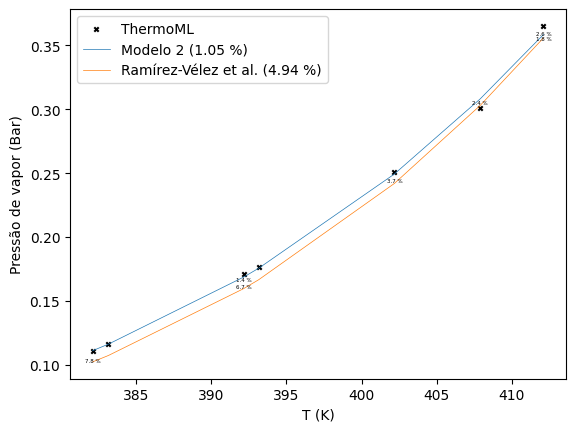

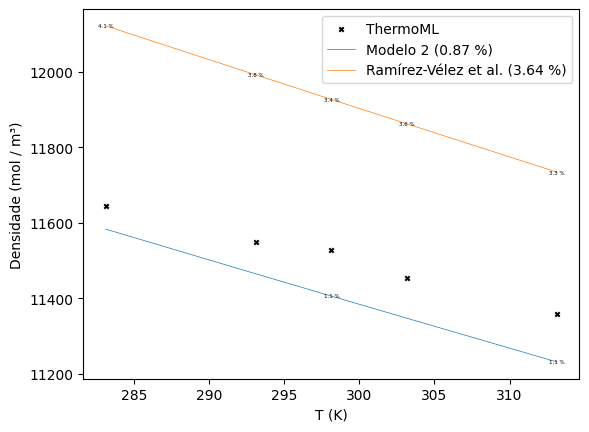

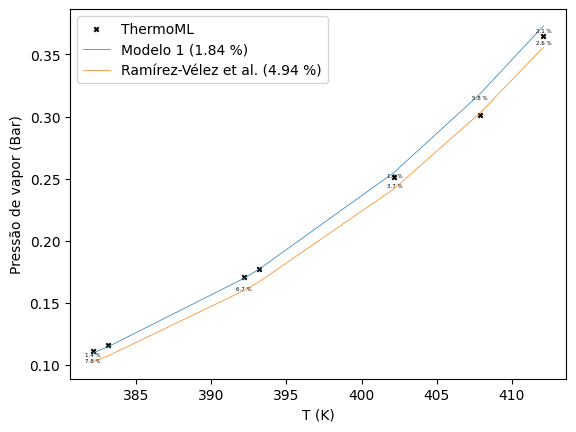

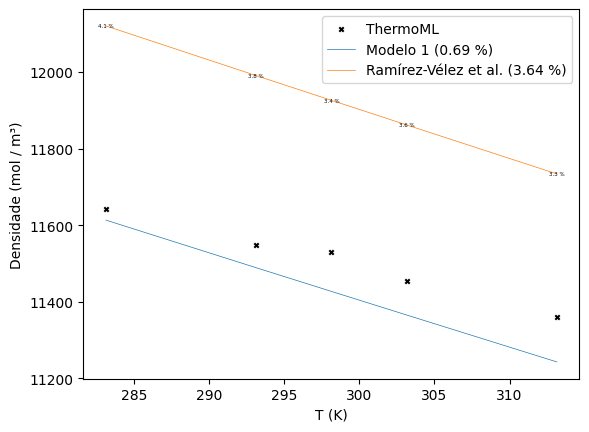

In [33]:
inchi = inchi
plotdata(inchi, "Modelo 2", "furfural", model2, testloader, ra_para)
plotdata(inchi, "Modelo 1", "furfural", model1, testloader, ra_para)